In [1]:
# If running notebook on brainlife, use ! due to version issues
# !pip install llvmlite --ignore-installed # added due to issue with (un)installing correct version
# !pip install git+https://github.com/JulioAPeraza/gradec.git

In [17]:
import itertools
import os.path as op
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_surf_maps, plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib

### Determine tract names given a data folder with cortical surface termination maps

In [29]:
# Path to cortical surface termination maps
data_dir = op.join(".", "data")
endpt_dir = op.join(
    data_dir, 
    "white-matter-atlas_thresholds", 
    f"cortexmap_binarize_smooth-surf-1_threshold-0_dilate-0", # MAY NEED TO MODIFY thresh and dilate
    "cortexmap", 
    "func",
)

# extract all .gii file names
file_names = []
for f in os.listdir(endpt_dir):
    if f.endswith(".gii"):
        file_names.append(f)

tracts_names = [] # all tract names differeniating between left and right tract (ex. left CST and right CST treated as 2 tracts)

# extract tract name from file name
for i in file_names:
    if ("rh.left" in i) or ("lh.right" in i): 
        continue # exclude if file name "rh.left..." or "lh.right..."
    else:
        tracts_names.append(i.split("_")[0][len('rh.'):])

ALL_TRACT_NAMES = sorted(list(set(tracts_names)))
len(ALL_TRACT_NAMES)
# note: mono_tracts includes 5 tracts + bi_tracts include 28 --> 5 + 28*2 = 61 major white matter tracts or ROIs??

61

In [19]:
''' USE ONLY IF WANTING TO SPLIT BY HEMISPHERE OR ROI LATER IN CODE
bi_tract_names = [] # tracts with left and right tract (lh-LPI, lh-RAS, rh-LPI, rh-RAS)
mono_tract_names = [] # tracts with no left and right tract (lh-LPI, rh-RAS)

# for use inside for loop below
LENGTH_HEM = len('rh.')
LENGTH_LEFT = len('left')
LENGTH_RIGHT = len('right')

# extract tract name from file name excluding 'left' or 'right's
for i in file_names:
    if ("rh.left" in i) or ("lh.right" in i): 
        continue # exclude if file name "rh.left..." or "lh.right..."
    else:
        split_by_tract = i.split("_")[0][LENGTH_HEM:]
        if 'left' in split_by_tract:
            bi_tract_names.append(split_by_tract[LENGTH_LEFT:])
        elif 'right' in split_by_tract:
            bi_tract_names.append(split_by_tract[LENGTH_RIGHT:])
        else:
            mono_tract_names.append(split_by_tract)

mono_tract_names = sorted(list(set(mono_tract_names))) # sorted to keep order consistent for future indexing
bi_tract_names = sorted(list(set(bi_tract_names))) # sorted to keep order consistent for future indexing

# create single array with tract names and whether the tracts are mono or bi
ALL_TRACT_NAMES = mono_tract_names + bi_tract_names
isMono = np.concatenate((np.ones(len(mono_tract_names), dtype=int),
                         np.zeros(len(bi_tract_names), dtype=int)))
MONO_OR_BI_DICT = dict(zip(ALL_TRACT_NAMES, isMono)) # binary, 1 = mono tract, 0 = bi tract
'''

' USE ONLY IF WANTING TO SPLIT BY HEMISPHERE OR ROI LATER IN CODE\nbi_tract_names = [] # tracts with left and right tract (lh-LPI, lh-RAS, rh-LPI, rh-RAS)\nmono_tract_names = [] # tracts with no left and right tract (lh-LPI, rh-RAS)\n\n# for use inside for loop below\nLENGTH_HEM = len(\'rh.\')\nLENGTH_LEFT = len(\'left\')\nLENGTH_RIGHT = len(\'right\')\n\n# extract tract name from file name excluding \'left\' or \'right\'s\nfor i in file_names:\n    if ("rh.left" in i) or ("lh.right" in i): \n        continue # exclude if file name "rh.left..." or "lh.right..."\n    else:\n        split_by_tract = i.split("_")[0][LENGTH_HEM:]\n        if \'left\' in split_by_tract:\n            bi_tract_names.append(split_by_tract[LENGTH_LEFT:])\n        elif \'right\' in split_by_tract:\n            bi_tract_names.append(split_by_tract[LENGTH_RIGHT:])\n        else:\n            mono_tract_names.append(split_by_tract)\n\nmono_tract_names = sorted(list(set(mono_tract_names))) # sorted to keep order con

### Define space, density and paths to data

In [30]:
SPACE, DENSITY = "fsaverage", "164k"
DSET, MODEL = "neuroquery", "lda"

# data_dir = op.join(".", "data") # duplicate from code above
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")

# List of possible combinations of tracts, end points and smoothing
tracts = ALL_TRACT_NAMES
endpts = ["RAS", "LPI"]
#tracts = ["Arc", "SLF1And2", "CST"]
#smths = ["", ".smooth_1"]
#thresholds = ["0", "0.15", "0.25"]

# Dictionaries for the title of the figures
TRACTS_DICT = dict(zip(ALL_TRACT_NAMES, ALL_TRACT_NAMES)) # need to eventually change
SMTHS_DICT = {
    "": "Unsmoothed",
    ".smooth_1": "Smoothed",
}
ENDPOINTS_DICT = { 
    "LPI": "Left-Posterior-Inferior",
    "RAS": "Right-Anterior-Superior",
}

### Train and LDA-based decoder on NeuroQuery detabase

In [31]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for analysis or visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

### Define functions to run decoder

In [32]:
def load_maps_per_tract(endpt_dir, tract):
    """
    This function loads maps when running analysis per tract (leftCST and rightCST = 2 tracts)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): full name of tract (ex. can include whether tract is 'left' or 'right' tract)

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if 'left' in tract:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
    elif 'right' in tract:
        map_lpi_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
    else: # if mono tract
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
        
    return map_arr_lh, map_arr_rh

In [5]:
def load_combined_maps(endpt_dir, tract, isMono):
    """
    This function loads maps when running analysis for combined endpoint ROIs (RAS+LPI)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if isMono:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
    else: # if bi tracts
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        
    return map_arr_lh, map_arr_rh

In [6]:
def load_mono_maps(endpt_dir, tract, method=""):
    """
    This function loads maps when running analysis for mono tracts, separated.
    Can be separated by hemisphere (lh vs. rh) or endpoint ROI (LPI vs. RAS). Functionally, these two are the same.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match method:
        case "lh": # separated by lh or LPI
            map_arr_lh = nib.load(map_lpi_lh).agg_data()
            map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
        case "rh": # separated by rh or RAS
            map_arr_rh = nib.load(map_ras_rh).agg_data()
            map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
        case _: # default
            print("Error: No separation method provided.")
    
    return map_arr_lh, map_arr_rh

In [7]:
def load_bi_maps(endpt_dir, tract, splitby="", endpt="", hemisphere=""):
    """
    This function loads maps when running analysis for bi tracts, separated.
    Can be separated by hemisphere (lh vs. rh), endpoint ROI (LPI vs. RAS), or both.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    splitby (str): method of splitting. Can split by "roi", "hem", or "both"
    endpt (str): optional- endpoint ROI. "RAS" or "LPI"
    hemisphere (str): optional- hemisphere. "lh" or "rh"

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    LH = "lh" # left hemisphere
    RH = "rh" # right hemisphere
    LPI = "LPI" # endpoint ROI: left-posterior-inferior
    RAS = "RAS" # endpoint ROI: right-anterior-superior

    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match splitby:
        case "roi": # separated by endpoint ROI
            if endpt == LPI: 
                map_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_arr_rh = nib.load(map_lpi_rh).agg_data()
            elif endpt == RAS:
                map_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_rh = nib.load(map_ras_rh).agg_data()
            else:
                print("Error: Can't separate by endpoint ROI. Wrong ROI provided.")
        case "hem": # separated by hemisphere
            if hemisphere == LH:
                map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
                map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
                map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere 
            else:
                print("Error: Can't separate by hemisphere. Wrong hemisphere provided.")
        case "both": # separated by enpoint ROI and hemisphere
            if hemisphere == LH:
                map_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_lh = nib.load(map_lh).agg_data()
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_rh = nib.load(map_rh).agg_data()
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere
            else:
                print("Error: Can't separate by endpoint ROI and hemisphere. Incorrect ROI or hemisphere provided.")
        case _: # default
            print("Error: Incorrect separation method provided.")
 
    return map_arr_lh, map_arr_rh

### (RUN THIS) Clustering: Run decoder for each tract

In [40]:
tracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*33 ROIs data table in long form

for tract in tracts_to_analyze:
    # Read map
    map_arr_lh, map_arr_rh = load_maps_per_tract(endpt_dir, tract)

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    '''
    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        data_dir=data_dir,
        out_fig=op.join(figures_dir, f"{tract}_LPI+RAS_thr-0_surf.png"),
    ) 
    '''

    # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # filter to keep only the function-related topics
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        temp_corrs_df,
        features,
        classification,
        pos_corr = False,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    # transform and concat into single df for clustering
    filtered_df = filtered_df.rename(columns={0: 'r'})
    sorted_df = filtered_df.sort_values(by="r", ascending=False)
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{tract}",
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_1355/1464217892.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Clustering: Run decoder on each endpoint separately

In [45]:
'''
# All variables for decoder method

# constants for separation method of bi tracts used inside for loop
SPLIT_ROI = "roi"
SPLIT_HEM = "hem"
SPLIT_BOTH = "both"

# modify to run a few tract, lh or rh, lpi or ras
tracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts
hemispheres_to_analyze = ["rh", "lh"]
endpts_to_analyze = ["LPI", "RAS"]
# modify this to choose to split by endpoint ROI (lpi vs. ras), hemisphere (lh vs. rh), or both
split_method = SPLIT_HEM
'''

'\n# All variables for decoder method\n\n# constants for separation method of bi tracts used inside for loop\nSPLIT_ROI = "roi"\nSPLIT_HEM = "hem"\nSPLIT_BOTH = "both"\n\n# modify to run a few tract, lh or rh, lpi or ras\ntracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts\nhemispheres_to_analyze = ["rh", "lh"]\nendpts_to_analyze = ["LPI", "RAS"]\n# modify this to choose to split by endpoint ROI (lpi vs. ras), hemisphere (lh vs. rh), or both\nsplit_method = SPLIT_HEM\n'

In [ ]:
'''
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*ROIs data table in long form. Can be anywhere from 33~61 ROIs.

# to keep track of lh-LPI, rh-RAS for mono tracks to not have duplicate iterations
do_not_run_dict = {"lhLPI": False, "rhRAS": False, "lhRAS": True, "rhLPI": True} # true = do not run 
prevTract = ""
endpt = "LPI"

for fig_i, (tract, hem) in enumerate(itertools.product(tracts_to_analyze, hemispheres_to_analyze)): # iterate through endpt
    # Read map
    if MONO_OR_BI_DICT.get(tract): # if mono tract
        if prevTract != tract: # if new track iteration, reset values
            do_not_run_dict["lhLPI"] = False
            do_not_run_dict["rhRAS"] = False
        if do_not_run_dict[hem+endpt]: # check if need to run iteration
            continue
        else:
            map_arr_lh, map_arr_rh = load_mono_maps(endpt_dir, tract, hem)
            do_not_run_dict[hem+endpt] = True
        prevTract = tract
    else: # if bi tract
        map_arr_lh, map_arr_rh = load_bi_maps(endpt_dir, tract, split_method, hemisphere=hem) # CHANGE SPLIT METHOD HERE, endpt=endpt

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} LPI+RAS\nNo smoothing. Threshold: 0", # MAY NEED TO CHANGE THRESHOLD OR SMOOTHING 
        data_dir=data_dir,
        out_fig=op.join(figures_dir, f"{fig_i}-01_{tract}_{hem}_{endpt}_thr-0_surf.png"),
    )

    # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # filter to keep only the function-related topics
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        temp_corrs_df,
        features,
        classification,
        pos_corr = False,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    # transform and concat into single df for clustering
    filtered_df = filtered_df.rename(columns={0: 'r'})
    sorted_df = filtered_df.sort_values(by="r", ascending=False)
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{hem}_{tract}", #endpt
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)
'''

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_371334/2745060278.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Clustering: Run decoder on each endpoint ROI combined

In [94]:
'''
tracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*33 ROIs data table in long form

for tract in tracts_to_analyze:
    # Read map
    map_arr_lh, map_arr_rh = load_combined_maps(endpt_dir, tract, MONO_OR_BI_DICT.get(tract))

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} LPI+RAS\nNo smoothing. Threshold: 0", # MAY NEED TO CHANGE THRESHOLD OR SMOOTHING 
        data_dir=data_dir,
        out_fig=op.join(figures_dir, f"{fig_i}-01_{tract}_LPI+RAS_thr-0_surf.png"),
    )

    # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # filter to keep only the function-related topics
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        temp_corrs_df,
        features,
        classification,
        pos_corr = False,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    # transform and concat into sinlge df for clustering
    filtered_df = filtered_df.rename(columns={0: 'r'})
    sorted_df = filtered_df.sort_values(by="r", ascending=False)
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{tract}_LPI+RAS",
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)
'''

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_1646/3936272803.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Clustering: Hierarchical cluster analysis

In [41]:
# constant to choose whether to cluster by topic or endpoint ROI
TOPIC = 't'
ROI = 'r'

clusterby = ROI # CHANGE THIS!!!

# transform and clean df
if clusterby == ROI:
    pivot_df = map_corr_df.pivot(index = 'topic', columns='ROI', values='r') # pivot from long to wide
elif clusterby == TOPIC:
    pivot_df = map_corr_df.pivot(index = 'ROI', columns='topic', values='r') # pivot from long to wide
else:
    print("Error: Incorrect clustering method provided")
pivot_df_cleaned = pivot_df.dropna(axis=1) # drop cols with NA values
# note to self: pivot_df.to_csv('output.csv', index=True)

# compute correlation matrix and HCA
corr_mtrix = pivot_df_cleaned.corr(method='pearson') 

#### Check conditions

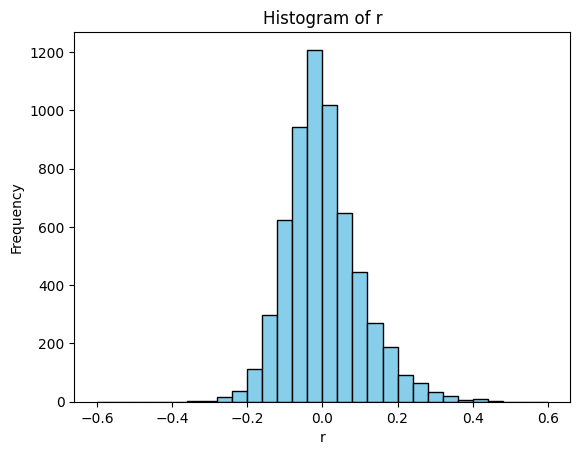

In [42]:
# Create a histogram
plt.hist(map_corr_df['r'], bins=30, range=(-0.6, 0.6),
         color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('r')
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format('r'))

# Show plot
plt.show()

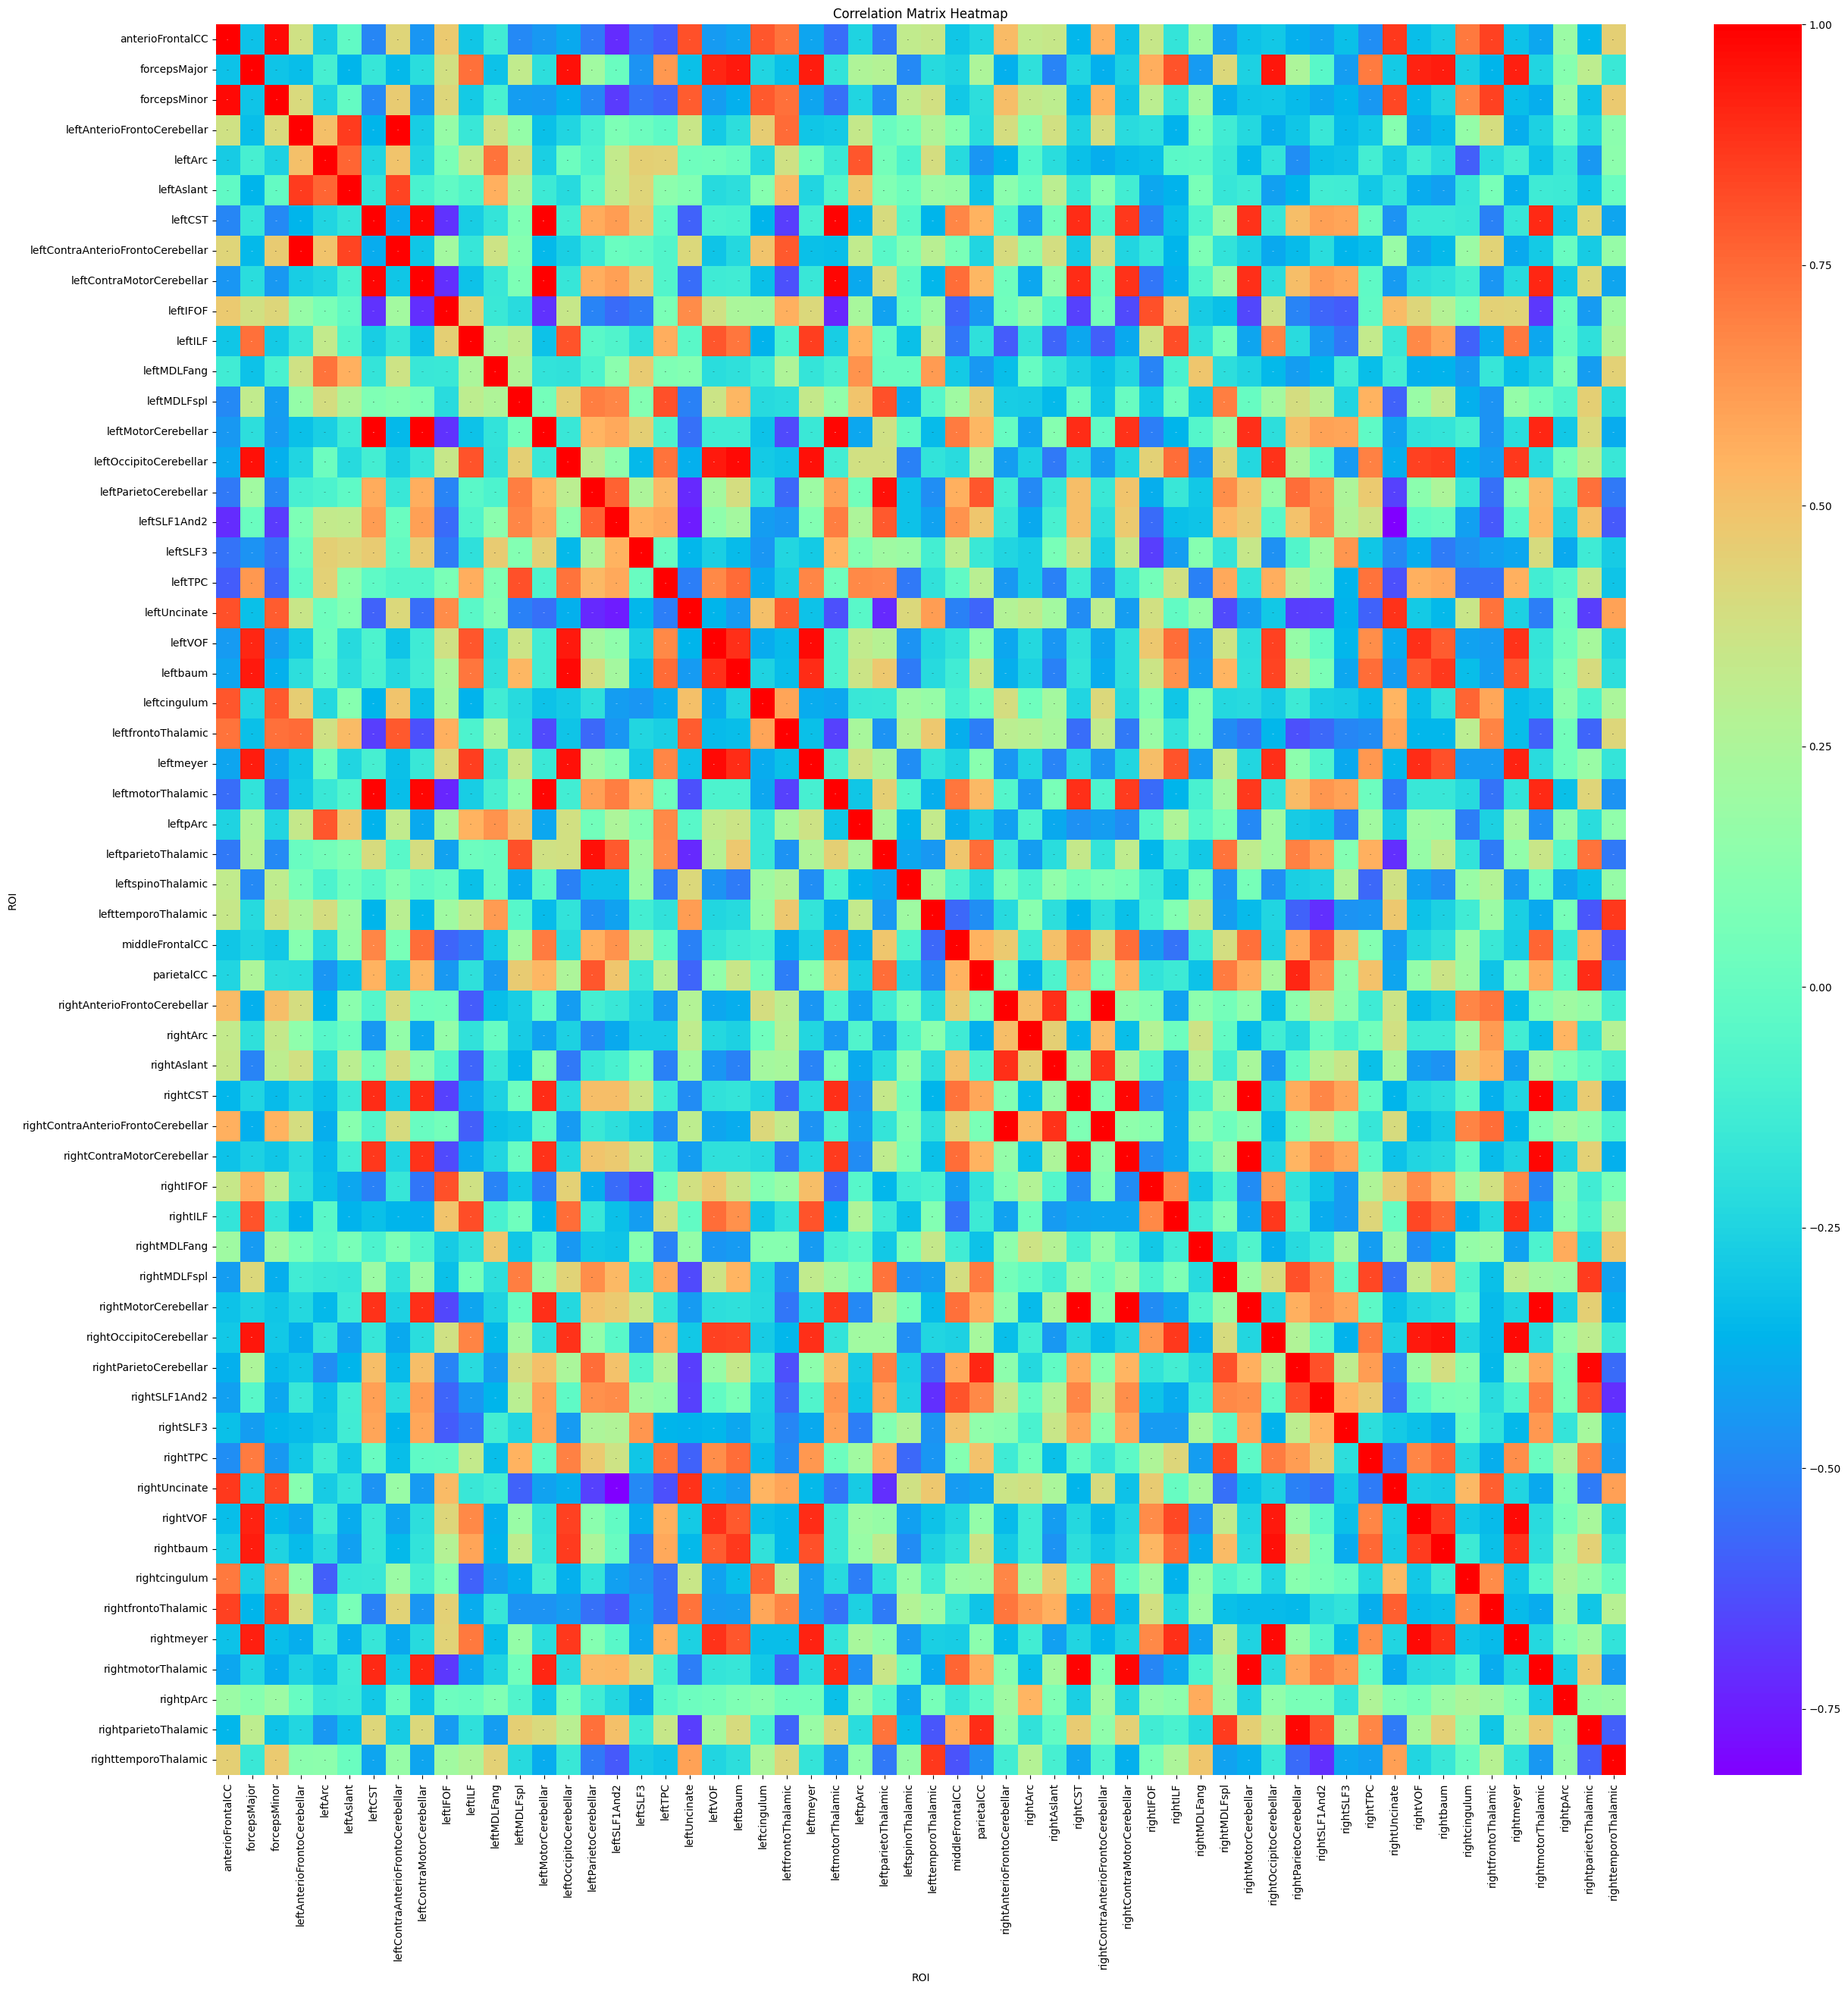

In [43]:
# Intermediate step: plot heatmap of the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mtrix, annot=True, cmap='rainbow', fmt=".2f", annot_kws={"fontsize": 1})
plt.title('Correlation Matrix Heatmap')
plt.show()

#### HCA

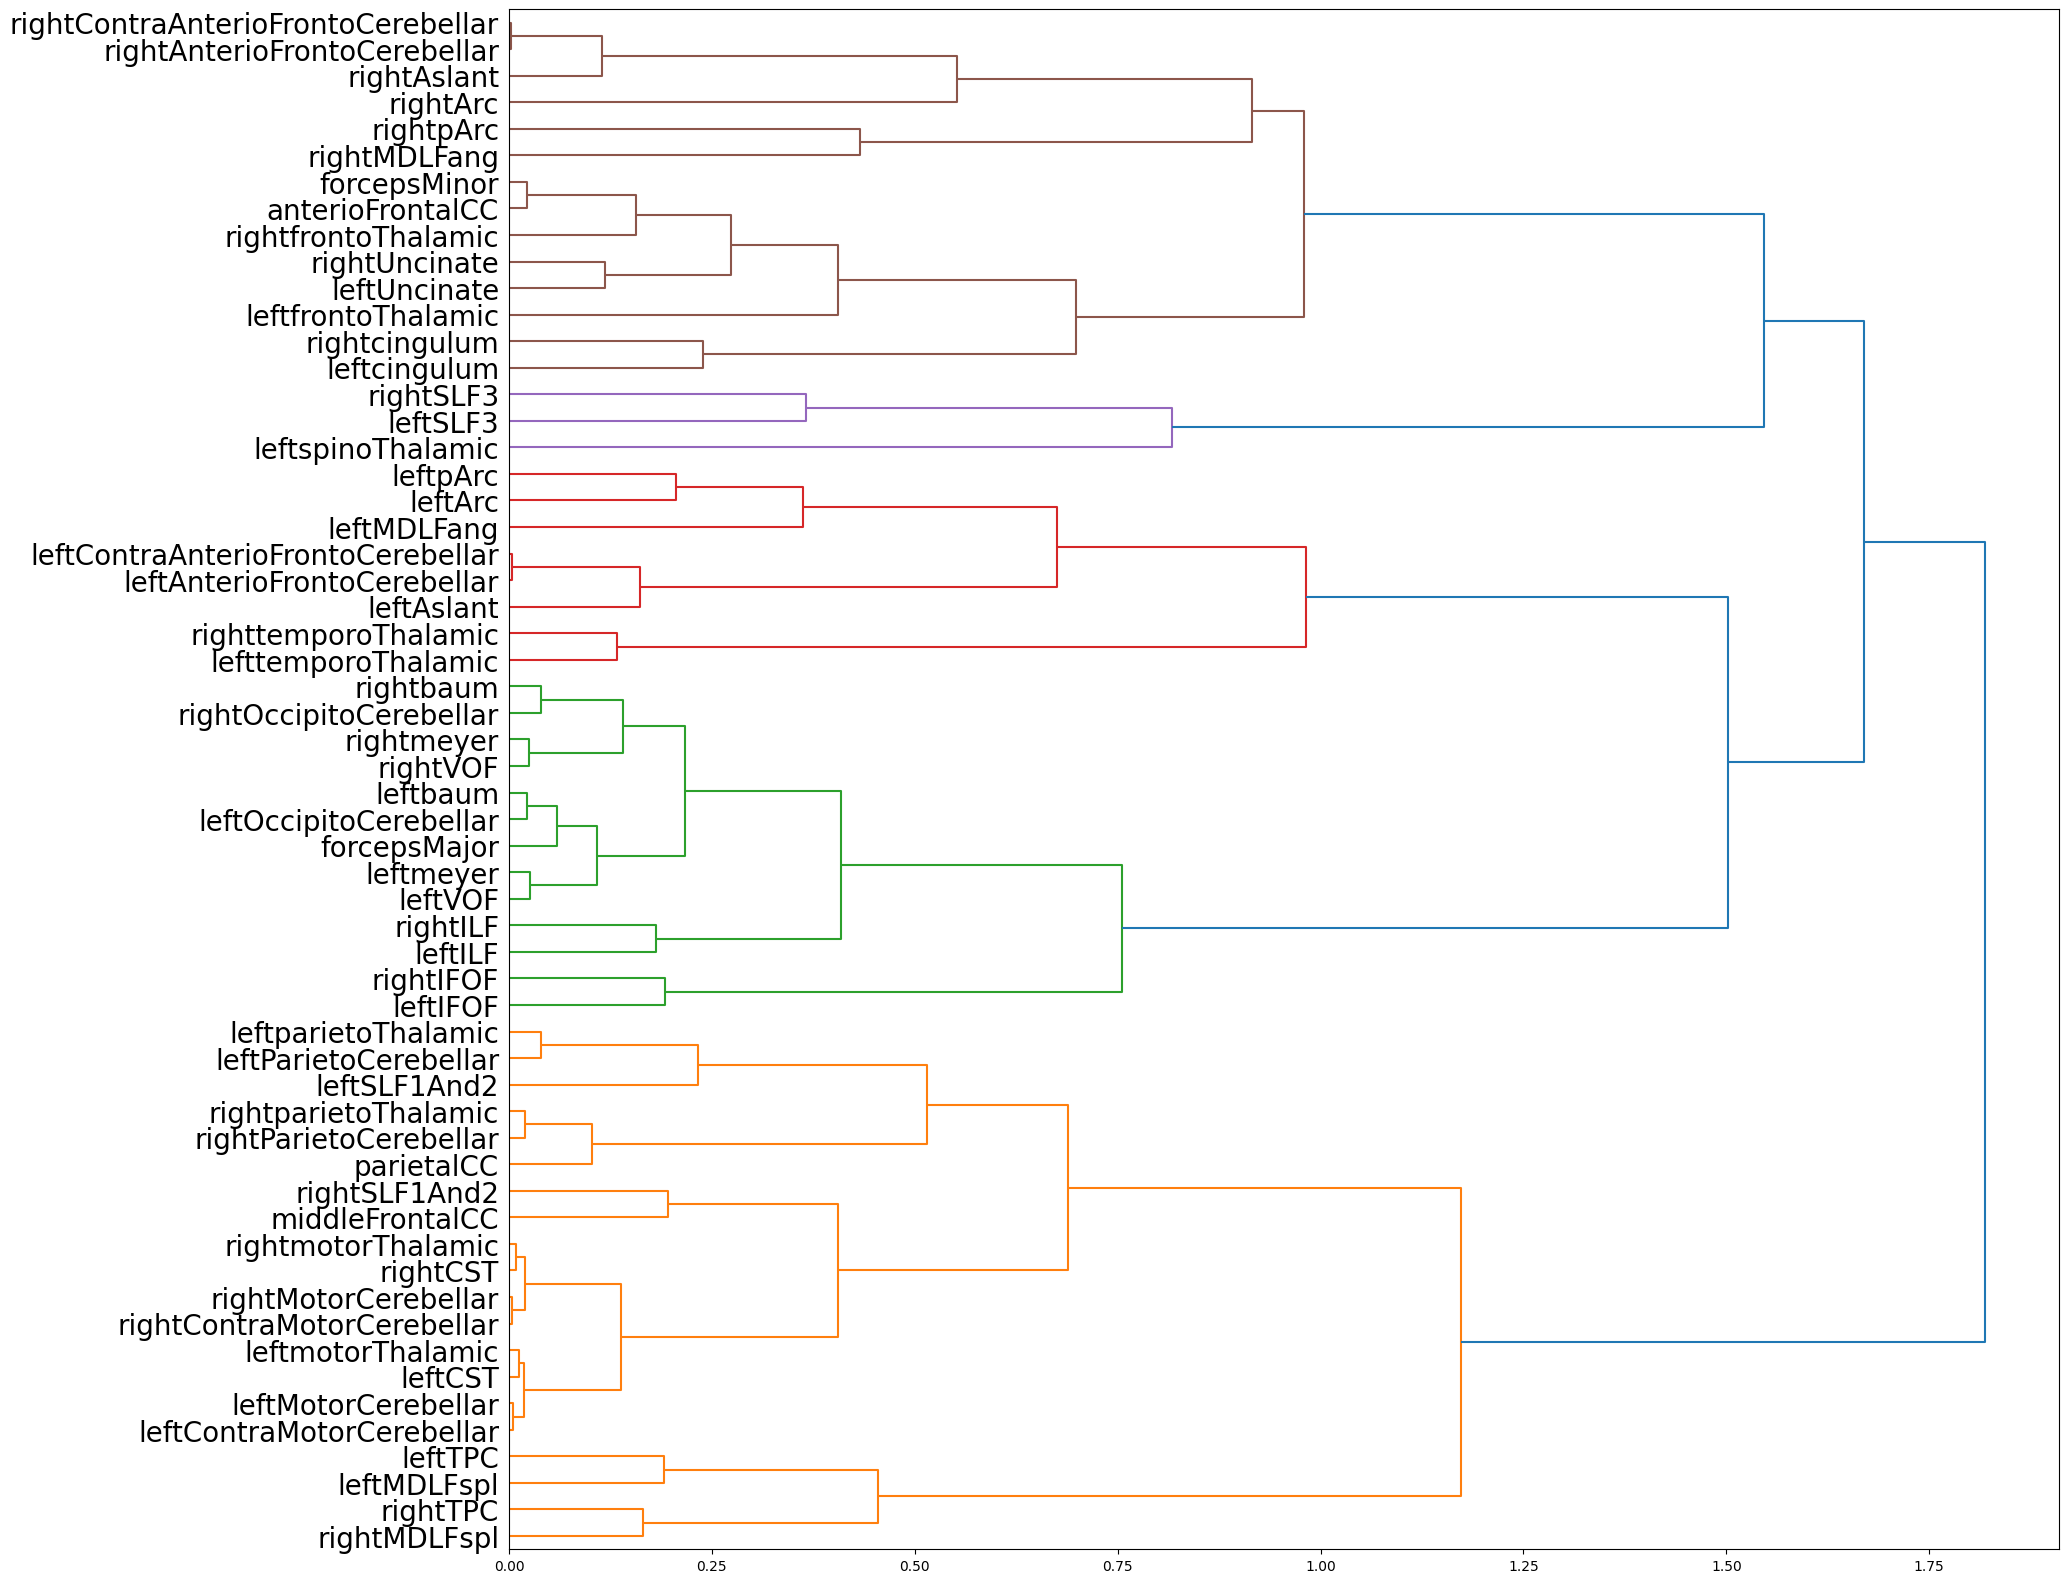

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree, inconsistent, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# HCA
link_method = 'complete'
dissimilarity = 1 - corr_mtrix # distance matrix
hca = linkage(squareform(dissimilarity), link_method)

# plot dendrogram
plt.figure(figsize=(20,20)) #45, 30
dendrogram(hca, labels=corr_mtrix.columns, 
           orientation='right',  
           leaf_font_size=20)
plt.savefig('./dendro_' + link_method + '.png', 
            bbox_inches = 'tight')
#thresh = 1.5
#plt.axhline(y=thresh, c='k')

<Figure size 800x600 with 0 Axes>

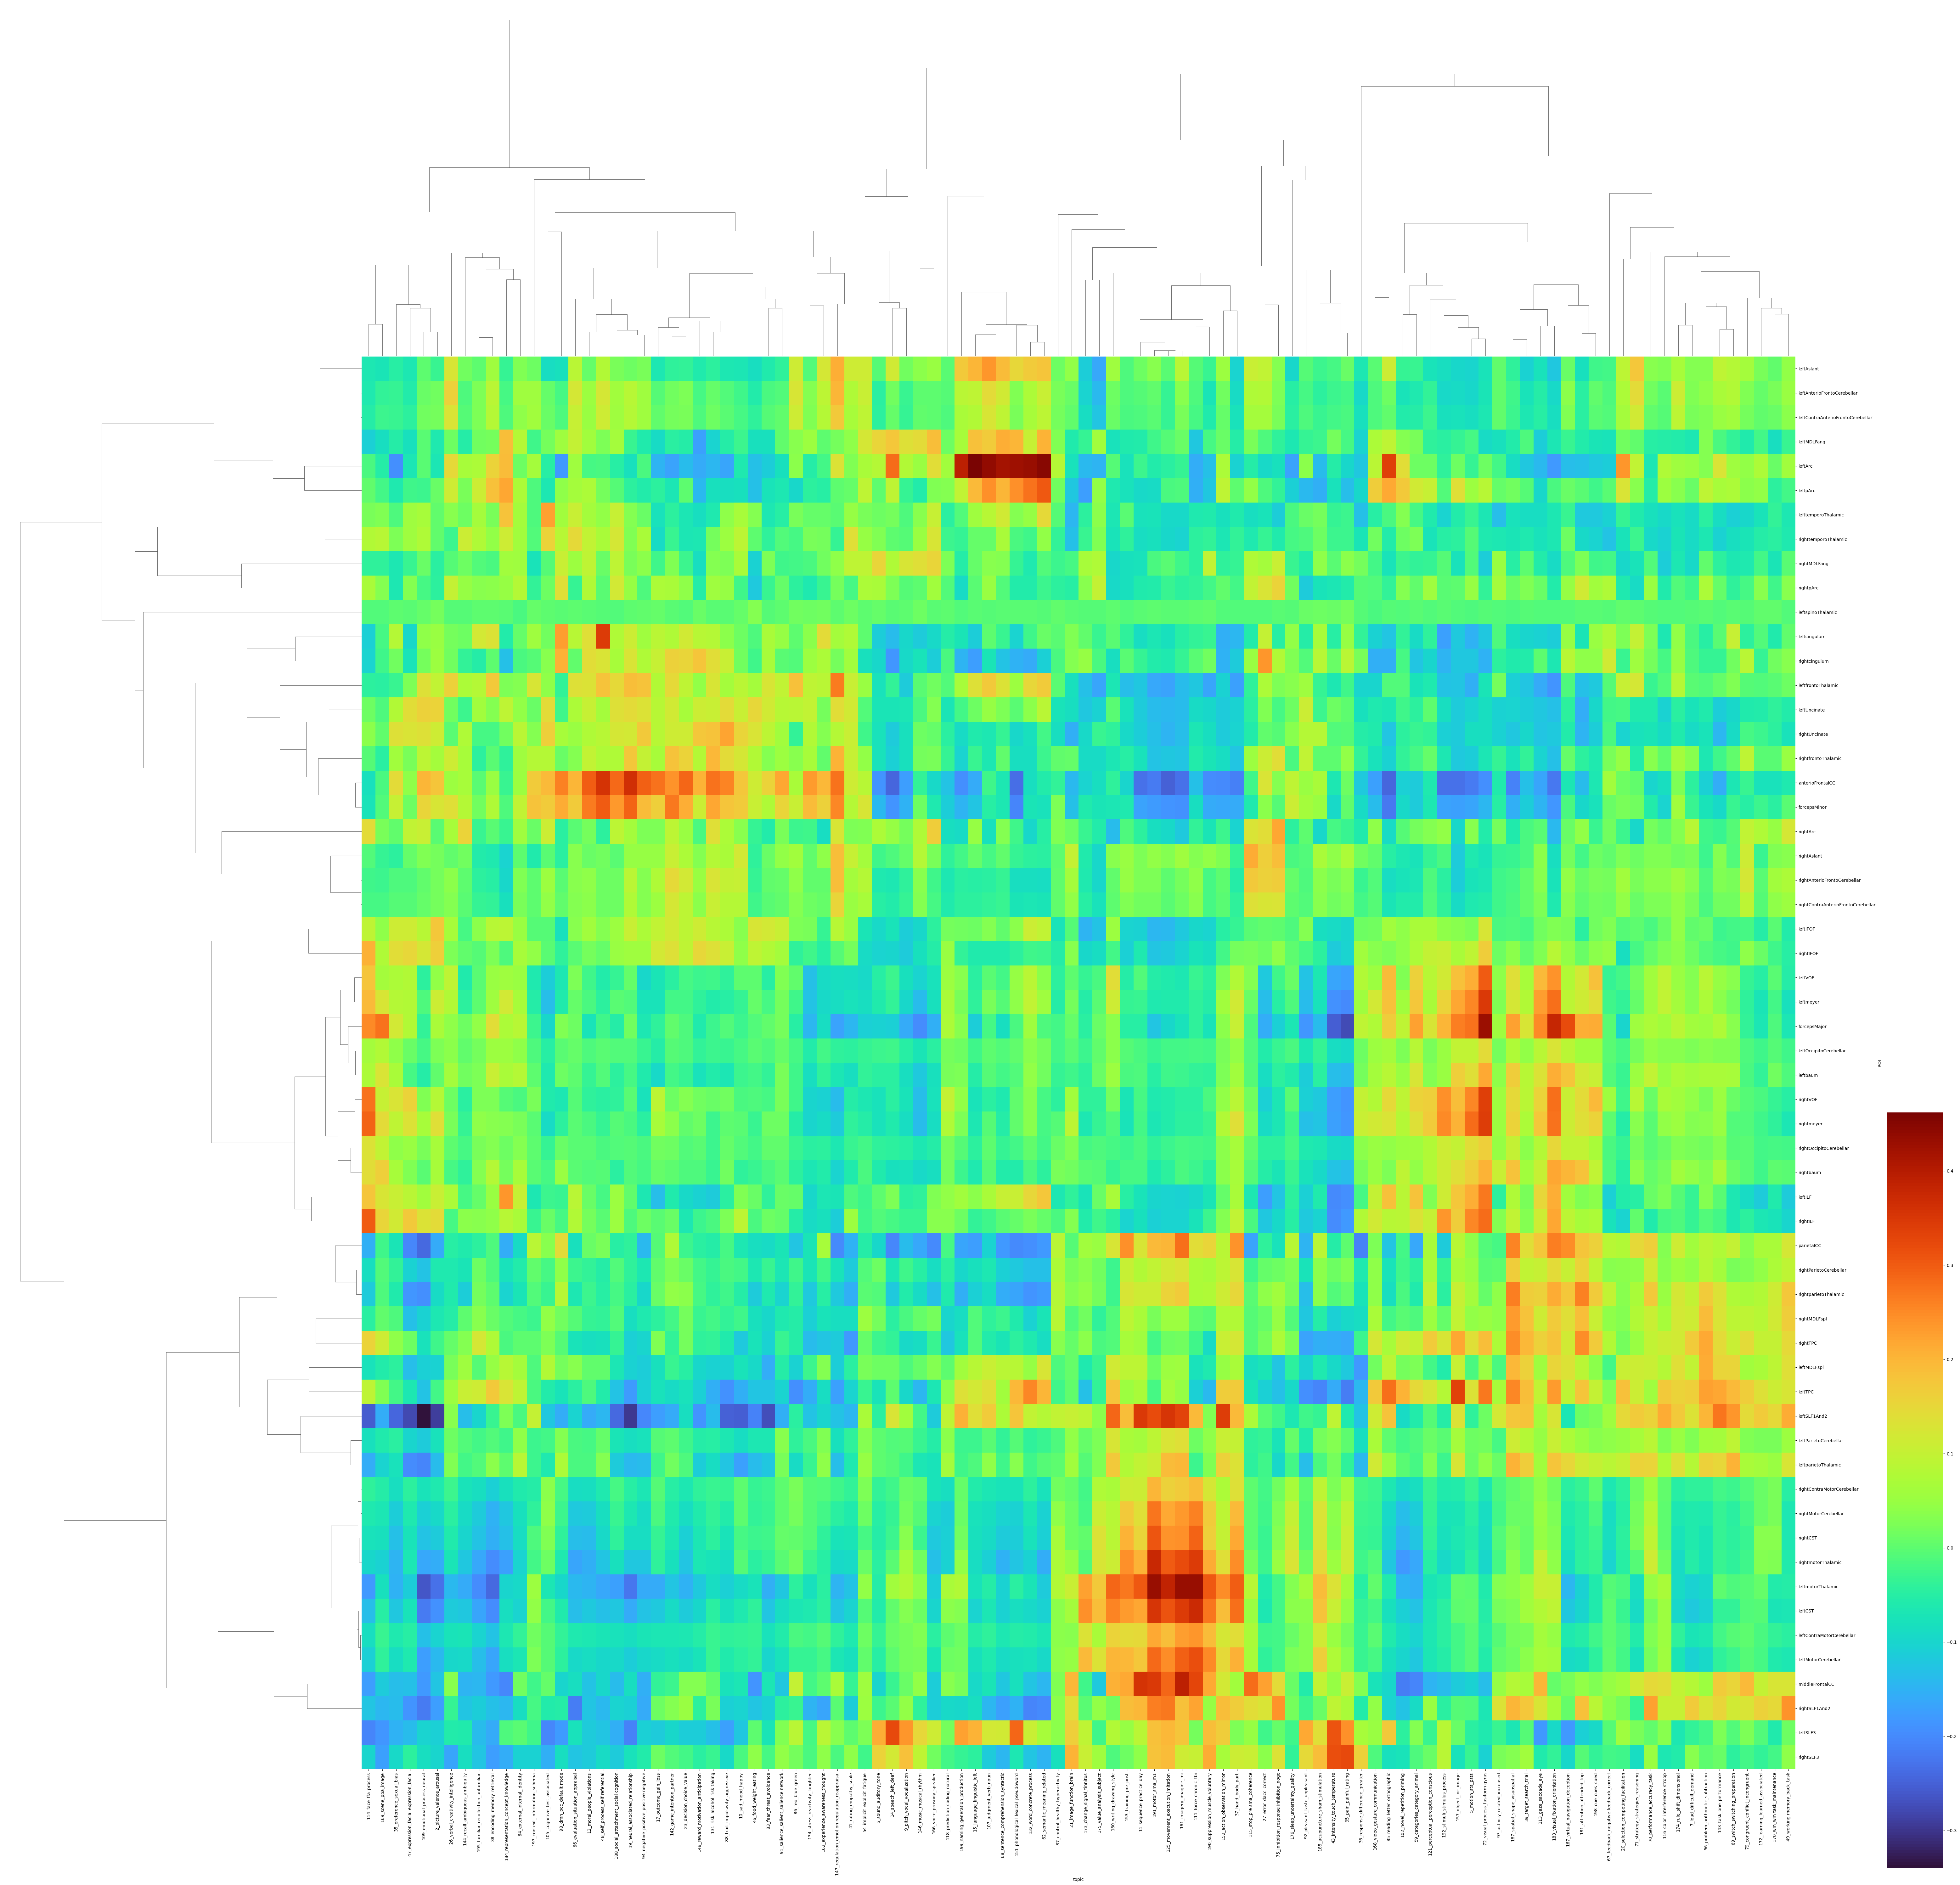

In [46]:
# Plot heatmap of the ordered matric
plt.figure(figsize=(8, 6))
sns.clustermap(pivot_df_cleaned.transpose(), #pivot_df_cleaned.drop(columns=col)
                metric="correlation",
                cmap='turbo', # turbo, terrain, gist_stern, gnuplot2, vlag
                cbar_pos=(1, .01, .03, .4),
                #standard_scale=1,
                #vmin=-.3, vmax=.5,
                #center=0,
                #z_score=1,
                square=False,
                figsize=(60,60)) #50, 50 
plt.savefig("heatmap.png")
plt.show()

In [50]:
pivot_df.index

Index(['102_novel_repetition_priming', '105_cognitive_test_associated',
       '107_judgment_verb_noun', '109_emotional_process_neural',
       '10_sad_mood_happy', '111_force_chronic_tbi', '113_gaze_saccade_eye',
       '114_face_ffa_process', '115_stop_pre sma_coherence',
       '116_color_interference_stroop',
       ...
       '86_red_blue_green', '87_control_healthy_hyperactivity',
       '88_trait_impulsivity_aggressive',
       '91_salience_salient_salience network', '92_pleasant_taste_unpleasant',
       '94_negative_positive_positive negative', '95_pain_painful_rating',
       '97_activity_related_increased', '98_dmn_pcc_default mode',
       '9_pitch_vocal_vocalization'],
      dtype='object', name='topic', length=104)

In [52]:
# create cluster dictionary
k = 8 # number of clusters. MODIFY THIS!
clusters = fcluster(hca, k, criterion='maxclust')

clusters_dict = {} # dictionary to store cluster assignments and tract names

# Group tract names by cluster
for tract, cluster in zip(pivot_df.columns.tolist(), clusters):
    if cluster not in clusters_dict:
        clusters_dict[cluster] = [tract]
    else:
        clusters_dict[cluster].append(tract)

# plot combined surf map for clusters
i = 0 # counter for file name

# iterate through all clusters and print out surface map for each cluster
for cluster, tracts in clusters_dict.items():
    cluster_map_arr_lh = np.zeros_like(map_arr_lh)
    cluster_map_arr_rh = np.zeros_like(map_arr_rh)
    print("Processing cluster " + str(i))
    for tract in tracts:
        map_arr_lh, map_arr_rh = load_maps_per_tract(endpt_dir, tract)

        # Remove medial wall
        map_arr = _rm_medial_wall(
            map_arr_lh,
            map_arr_rh,
            space=SPACE,
            density=DENSITY,
            neuromaps_dir=neuromaps_dir,
        )

        cluster_map_arr_lh = np.maximum(cluster_map_arr_lh, map_arr_lh) # Take the maximum to address overlap
        cluster_map_arr_rh = np.maximum(cluster_map_arr_rh, map_arr_rh) # Take the maximum to address overlap

    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        cluster_map_arr_lh, 
        cluster_map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title = "cluster_" + str(i),
        data_dir=data_dir,
        out_fig=op.join(f"cluster_{i}_thr-0_surf.png"),
    ) 
    i += 1

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6
Processing cluster 7


### Visualization: Run decoder on each regions separate

In [55]:
sep_figures_dir = op.join(figures_dir, "separated")
os.makedirs(sep_figures_dir, exist_ok=True)

separated_results = {}
for fig_i, (threshold, tract, region, smth) in enumerate(itertools.product(thresholds, tracts, regions, smths)):
    # Path to the maps
    regions_dir = op.join(
        data_dir, 
        "white-matter-atlas_thresholds", 
        f"cortexmap_binarize_smooth-surf-1_threshold-{threshold}_dilate-0", 
        "cortexmap", 
        "func",
    )
    
    # Read maps
    map_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_{region}_FiberEndpoint{smth}.func.gii")
    map_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_{region}_FiberEndpoint{smth}.func.gii")
    map_arr_lh = nib.load(map_lh).agg_data()
    map_arr_rh = nib.load(map_rh).agg_data()

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map
    corrs_df = decode.transform([map_arr], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )
    filtered_df.columns = ["r"]
    separated_results[f"{tract}_{region}{smth}_thr-{threshold}"] = filtered_df.sort_values(by="r", ascending=False)

    # Visualize maps to decode
    plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} {REGIONS_DICT[region]}\n{SMTHS_DICT[smth]}. Threshold: {threshold}",
        data_dir=data_dir,
        out_fig=op.join(sep_figures_dir, f"{fig_i}-01_{tract}_{region}{smth}_thr-{threshold}_surf.png"),
    )

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    if not np.any(np.isnan(corrs)) and corrs.size > 0: # Skip one of the regions of CST
        # Radar plot
        plot_radar(
            corrs, 
            filtered_features, 
            MODEL,
            out_fig=op.join(sep_figures_dir, f"{fig_i}-02_{tract}_{region}{smth}_thr-{threshold}_radar.png"),
        )
        
        # Word cloud plot
        plot_cloud(
            corrs, 
            filtered_features,
            MODEL,
            frequencies=filtered_frequencies,
            out_fig=op.join(sep_figures_dir, f"{fig_i}-03_{tract}_{region}{smth}_thr-{threshold}_wordcloud.png"),
        )

  0%|          | 0/1 [00:00<?, ?it/s]
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/numpy/lib/npyio.py:1393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)
  0%|          | 0/1 [00:00<?, ?it/s]
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/numpy/lib/npyio.py:1393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/nimare/stats.py:109: RuntimeWarning: invalid value encounte

### Visualization: Run decoder on combined regions for each tract

In [20]:
com_figures_dir = op.join(figures_dir, "combined")
os.makedirs(com_figures_dir, exist_ok=True)

combined_results = {}
for fig_i, (threshold, tract, smth) in enumerate(itertools.product(thresholds, tracts, smths)):
    # Path to the maps
    regions_dir = op.join(
        data_dir, 
        "white-matter-atlas_thresholds", 
        f"cortexmap_binarize_smooth-surf-1_threshold-{threshold}_dilate-0", 
        "cortexmap", 
        "func",
    )
    
    # Read maps
    map_lpi_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint{smth}.func.gii")
    map_lpi_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint{smth}.func.gii")
    map_ras_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint{smth}.func.gii")
    map_ras_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint{smth}.func.gii")
    
    map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
    map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
    map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
    map_ras_arr_rh = nib.load(map_ras_rh).agg_data()

    # Combined regions for each tract
    map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
    map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
    
    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map
    corrs_df = decode.transform([map_arr], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    filtered_df.columns = ["r"]
    combined_results[f"{tract}{smth}_thr-{threshold}"] = filtered_df.sort_values(by="r", ascending=False)

    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} LPI+RAS\n{SMTHS_DICT[smth]}. Threshold: {threshold}",
        data_dir=data_dir,
        out_fig=op.join(com_figures_dir, f"{fig_i}-01_{tract}_LPI+RAS{smth}_thr-{threshold}_surf.png"),
    )

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    if not np.any(np.isnan(corrs)) and corrs.size > 0: # Skip one of the regions of CST
        # Radar plot
        plot_radar(
            corrs, 
            filtered_features, 
            MODEL,
            out_fig=op.join(com_figures_dir, f"{fig_i}-02_{tract}_LPI+RAS{smth}_thr-{threshold}_radar.png"),
        )

        # Word cloud plot
        plot_cloud(
            corrs, 
            filtered_features,
            MODEL,
            frequencies=filtered_frequencies,
            out_fig=op.join(com_figures_dir, f"{fig_i}-03_{tract}_LPI+RAS{smth}_thr-{threshold}_wordcloud.png"),
        )

  0%|          | 0/1 [00:00<?, ?it/s]
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/nimare/stats.py:109: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])
  0%|          | 0/1 [00:00<?, ?it/s]


115119

### Visualizaiton: Make figures - Julio's version

In [24]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

In [25]:
comb_width, comb_hight = 25, 13
sep_width, sep_hight = 25, 25

n_comb_rows, n_comb_cols = 3, 6
n_sep_rows, n_sep_cols = 6, 6

In [26]:
fig_i = 0
for thr_i, threshold in enumerate(thresholds):
    fig = plt.figure(figsize=(sep_width, sep_hight))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    gs = GridSpec(nrows=n_sep_rows, ncols=n_sep_cols, figure=fig)

    for trc_i, tract in enumerate(tracts):
        for reg_i, region in enumerate(regions):
            for smth_i, smth in enumerate(smths):
                surf_plt = op.join(sep_figures_dir, f"{fig_i}-01_{tract}_{region}{smth}_thr-{threshold}_surf.png")
                radar_plt = op.join(sep_figures_dir, f"{fig_i}-02_{tract}_{region}{smth}_thr-{threshold}_radar.png")
                wordcloud_plt = op.join(sep_figures_dir, f"{fig_i}-03_{tract}_{region}{smth}_thr-{threshold}_wordcloud.png")

                for img_i, img_file in enumerate([surf_plt, radar_plt, wordcloud_plt]):
                    ax = fig.add_subplot(gs[trc_i*2 + reg_i, smth_i*3 + img_i], aspect="equal")
                    if op.exists(img_file):
                        img = mpimg.imread(img_file)    
                        ax.imshow(img)

                    ax.set_axis_off()

                fig_i += 1

        out_file = op.join(figures_dir, f"results-separated_thr-{float(threshold):.2f}.png")
        fig.savefig(out_file, bbox_inches="tight", dpi=300)
        plt.close()

IndexError: index 6 is out of bounds for axis 0 with size 6

In [10]:
fig_i = 0
for thr_i, threshold in enumerate(thresholds):
    fig = plt.figure(figsize=(comb_width, comb_hight))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    gs = GridSpec(nrows=n_comb_rows, ncols=n_comb_cols, figure=fig)

    for trc_i, tract in enumerate(tracts):
        for smth_i, smth in enumerate(smths):

            surf_plt = op.join(com_figures_dir, f"{fig_i}-01_{tract}_LPI+RAS{smth}_thr-{threshold}_surf.png")
            radar_plt = op.join(com_figures_dir, f"{fig_i}-02_{tract}_LPI+RAS{smth}_thr-{threshold}_radar.png")
            wordcloud_plt = op.join(com_figures_dir, f"{fig_i}-03_{tract}_LPI+RAS{smth}_thr-{threshold}_wordcloud.png")
            
            for img_i, img_file in enumerate([surf_plt, radar_plt, wordcloud_plt]):
                ax = fig.add_subplot(gs[trc_i, smth_i*3 + img_i], aspect="equal")
                if op.exists(img_file):
                    img = mpimg.imread(img_file)    
                    ax.imshow(img)
                
                ax.set_axis_off()

            fig_i += 1

    out_file = op.join(figures_dir, f"results-combined_thr-{float(threshold):.2f}.png")
    fig.savefig(out_file, bbox_inches="tight", dpi=300)
    plt.close()